In [4]:
# IMPORT PYTHON LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print (tensorflow.__version__)

2.4.0-rc0


In [2]:
# Run this cell to load shuffled & temperature compensated data
examples = np.load('/Volumes/GoogleDrive/Shared drives/WindTunnelTests-Feb2019/Sept2020_Tests/Training_Tests/train4_Dec14/allExamples/examples_comp_std_prep_shuf.npy')
state = np.load('/Volumes/GoogleDrive/Shared drives/WindTunnelTests-Feb2019/Sept2020_Tests/Training_Tests/train4_Dec14/allExamples/state_std_prep_shuf.npy')
stall = np.load('/Volumes/GoogleDrive/Shared drives/WindTunnelTests-Feb2019/Sept2020_Tests/Training_Tests/train4_Dec14/allExamples/stall_std_prep_shuf.npy')

trainingX = examples
trainingState = state
trainingStall = stall

In [7]:
# Option 2 (1D Resnet):
# This works well with the following:
import pickle
import keras_resnet.models as krm
from sklearn import preprocessing
from tensorflow.keras.optimizers import Adam

# convert data to categorical
encoder = preprocessing.LabelEncoder()

state_categorical = encoder.fit_transform(trainingState)
stall_categorical = encoder.fit_transform(trainingStall)
trainingY = state_categorical ###Change this based on the output of interest###

#Prepare ResNet model
inp_shape = (trainingX.shape[1], trainingX.shape[2])
inp_tens = tf.keras.Input(shape=inp_shape)
class_cnt = max(trainingY) + 1
model = krm.ResNet1D34(classes=class_cnt)
outputs = model(inp_tens)

#Compiling the CNN
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

#Define model, compile, and fit
history = model.fit (trainingX, trainingY, batch_size=256, epochs = 75, verbose = 1, shuffle=False, validation_split=0.1)
with open(savepath+"tmpResNetModel_ignore.p", "wb") as file_pi:
  pickle.dump(history.history, file_pi)

StagingError: in user code:

    /Users/tanay/miniforge3/envs/python38/lib/python3.8/site-packages/keras_resnet/models/_1d.py:211 call  *
        return super(ResNet1D34, self).call(inputs)
    /Users/tanay/miniforge3/envs/python38/lib/python3.8/site-packages/keras_resnet/models/_1d.py:120 call  *
        if i == self.iters[0]:
    /Users/tanay/miniforge3/envs/python38/lib/python3.8/site-packages/tensorflow/python/training/tracking/data_structures.py:380 __getitem__
        return self._storage[key]

    IndexError: list index out of range


In [ ]:
# Export state encoder for decoding
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

state_categorical = encoder.fit_transform(trainingState)
with open(savepath+"resnet_encoder.p", "wb") as file_pi:
  pickle.dump(encoder, file_pi)
with open(savepath+"state_truth.p", "wb") as file_pi:
  pickle.dump(state_categorical, file_pi)

Model: "res_net1d18_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 233, 9)]     0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding1D)   (None, 239, 9)       0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 117, 64)      4032        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 117, 64)      256         conv1[0][0]                      
______________________________________________________________________________________

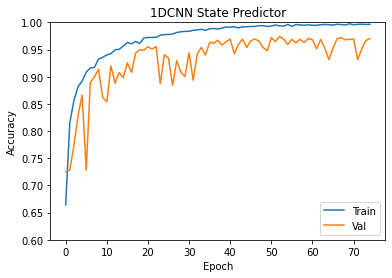

In [ ]:
#Viz the model & training history
import keras
import pickle
from keras.models import load_model
from keras.utils import plot_model
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import tensorflow.keras
import keras_resnet
import keras_resnet.models

leakyrelu = LeakyReLU(alpha=0.05)
resnet_model = keras_resnet.models.ResNet1D18(freeze_bn=True)
resnet_bn_layer = keras_resnet.layers.BatchNormalization(freeze=True)
folderpath = '/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Sept2020_Tests/Kerasfiles_Dec2020/'
filename = 'state_9sensors_train992_val972'

def visualizemodel():
  plot_model(classifier, to_file=folderpath+'Visualizations/'+filename+"_model.png", expand_nested=False)

def visualizetraining(history):
  fig = plt.figure()
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title ('1DCNN State Predictor')
  plt.ylabel ('Accuracy')
  plt.xlabel ('Epoch')
  plt.legend (['Train', 'Val'], loc='lower right')
  plt.ylim (0.6, 1.0)
  plt.show()
  fig.savefig(folderpath+'Visualizations/'+filename+'.png',dpi=300)

classifier = keras.models.load_model(folderpath+filename+".hdf5", custom_objects={'LeakyReLU': leakyrelu, 'ResNet1D18': resnet_model, 'BatchNormalization': resnet_bn_layer})
print (classifier.summary())
with open(folderpath+filename+'.p', 'rb') as file_pi:
  history = pickle.load(file_pi)

visualizetraining(history)